# Graph Neural Networks

In [63]:
import torch
from sklearn.metrics import balanced_accuracy_score
import torch.nn as nn
from tqdm.notebook import trange
from sklearn.manifold import TSNE
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

### CORA dataset

In [64]:
#For Colab (torch 2.5)
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html


In [65]:
import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import SAGEConv

In [66]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 10556/2 links. Let us take a closer look at this dataset. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [67]:
data = CoraGraphDataset(force_reload=True)

Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [68]:
graph = data[0]
graph

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

Adjacency matrix can be obtained as follows

In [69]:
adj = graph.adj().to_dense()
adj

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

Feature matrix is stored in node features `feat`.

In [70]:
feat = graph.ndata['feat']
print(feat.shape)
feat

torch.Size([2708, 1433])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In DGL, Cora feature matrix are normalized so that the sum per row is 1. Labels are represent type of the publication, they are stored in `label`.

In [71]:
label = graph.ndata['label']
label

tensor([3, 4, 4,  ..., 3, 3, 3])

Here are train, validation and test masks.

In [72]:
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
val_mask, train_mask, test_mask

(tensor([False, False, False,  ..., False, False, False]),
 tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([False, False, False,  ...,  True,  True,  True]))

### 1. Graph convolution as matrix product

Graph convolutional network (GCN) was proposed in [[1]](#references) and defined on an undirected graph as the following propagation rule:

$$H^{(l)}=\sigma\left(\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{(l-1)} W^{(l)}\right)$$

where $\tilde A = A + I_N$ is the adjacency matrix with added self-connections. $I_N$ is the identity matrix, $\tilde D_{ii} = \sum_j \tilde A_{ij}$ is the degree matrix and $W^{(l)}$ is trainable matrix at the layer $l$. $\sigma$ represents non-linear activation function such as ReLU. $H^{(l)}$ is the hidden states at the layer $l$ and $H^{(0)} = X$ is the initial feature matrix.

Write a class `GCNMatrixProductLayer` that takes adjacency matrix, hidden states and returns the next hidden states before activation.

In [73]:
class GCNMatrixProductLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, h):
        _adj = adj.clone()
        # YOUR CODE HERE
        _adj = _adj + torch.eye(_adj.shape[0])
        D_ = torch.sum(_adj, dim=1) ** (-0.5)
        return D_[:, None] * _adj * D_[None, :] @ self.dense(h)

        #raise NotImplementedError()

In [74]:
layer = GCNMatrixProductLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(adj, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

Write a class `GCNMatrixProduct` that takes the adjacency matrix and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [75]:
class GCNMatrixProduct(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.gcn1 = GCNMatrixProductLayer(in_dim , hid_dim)
        self.gcn2 = GCNMatrixProductLayer(hid_dim, out_dim)

    def forward(self, adj, feat):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h = self.gcn1(adj, feat)
        h = F.relu(h)
        h = self.gcn2(adj, h)
        return h

In [76]:
model = GCNMatrixProduct(2708, 32, 7)
logits = model(adj, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

Let us create the two-layer GCN for node classification task.

In [77]:
model = GCNMatrixProduct(1433, 32, 7)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

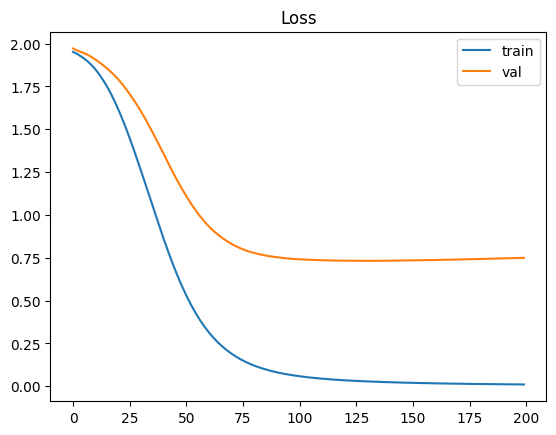

In [78]:
n_epochs = 200
for i in trange(n_epochs):

    logits = model(adj, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

We evaluate the model by balanced accuracy that accounts for inbalanced classes.

In [79]:
with torch.no_grad():
    logits = model(adj, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.81


### 2. Graph convolution as message passing

The original GCN is computationally expensive for large graphs since it requires to compute matrix product $\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{l}$, that costs $O(|V|^2)$. However, the information is propagated along edges, the number of which is linearly depends on the number of nodes in scale-free networks, that is $O(|V|)$. Message passing framework was proposed in [[2]](#references) to reduce computation costs by representing a graph neural network's layer as the composition of two functions:

$$m_{ij}^l = \text{Message}\left(h_i^{l-1}, h_j^{l-1}\right)$$
$$h_i^l = \text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}\left(m_{ji}^l\right)$$

where $\text{Message}(\cdot)$ is the message function that applied on each edges in the graph and stores computed values (messages) on edges. $\text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}(\cdot)$ is the reduce (aka aggregation, reduction) function that applied on each node and aggregates messages from incoming links (mailboxes).

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/messpass.png' width=600>

In particular, GCN can be represented as follows:

$$h_i^l = \sigma \left(W^l \sum_{j \in \mathcal{N}_\text{in}(i)}\frac{h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)||\mathcal{N}_\text{in}(i)|}}\right)$$

where the message function

$$m_{ji}^l = \frac{W^l h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)|}}$$

is the transformed source node's hidden state normalized by the in-degree of the source node. The reduce function

$$h_i^l = \sigma \left(\frac{\sum_{j \in \mathcal{N}_\text{in}(i)} m_{ji}^l}{\sqrt{|\mathcal{N}_\text{in}(i)|}}\right)$$

is the sum over all incoming neighbors' hidden states with in-degree normalization and subsequent activation $\sigma$. Here we assume that the graph includes self-connections, that is a node is in its neighborhood. We also assume that the graph is equivalent to its undirected representation, that is $A = A^\top$.

In DGL, message passing is applied by `graph.update_all(message_func, reduce_func)` where `message_func` is defined on edges and `reduce_func` on nodes. DGL contains built-in message and reduce functions, but it is also possible to define your own functions. GCN can be implemented using following functions:
* message function `fn.copy_u(u='h', out='m')` copies the source node feature `h` into the mailbox `m`
* reduce function `fn.sum(msg='m', out='h')` sums messages from mailboxes `m` and save the result into the node feature `h`

Write a class `GCNMessagePassingLayer` that takes a graph, hidden states and returns the next hidden states before activation.

*Hints:*
* _adding node features is similar to adding values to a dictionary: `graph.ndata['h'] = h`_
* _in-degrees can be computed by `graph.in_degrees()`_

*Remark: `graph.local_scope()` makes all operations isolated from the original graphs.*

In [80]:
class GCNMessagePassingLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    def forward(self, graph, h):
        with graph.local_scope():
            graph = graph.add_self_loop()
            # YOUR CODE HERE
            #raise NotImplementedError()
            norm = graph.in_degrees() [:, None] ** (-0.5)
            graph.ndata['h'] = self.dense(h) * norm

            graph.update_all(fn.copy_u(u='h', out='m'),
                             fn.sum(msg='m', out='h'))
        return graph.ndata['h'] * norm

In [81]:
layer = GCNMessagePassingLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(graph, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

Write a class `GCNMessagePassing` that takes the graph and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [82]:
class GCNMessagePassing(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.gcn1 = GCNMessagePassingLayer(in_dim , hid_dim)
        self.gcn2 = GCNMessagePassingLayer(hid_dim, out_dim)
    def forward(self, graph, feat):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h = self.gcn1(graph, feat)
        h = F.relu(h)
        h = self.gcn2(graph, h)
        return h

In [83]:
model = GCNMessagePassing(2708, 32, 7)
logits = model(graph, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

In [84]:
model = GCNMessagePassing(in_dim=1433, hid_dim=32, out_dim=7)
opt = Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

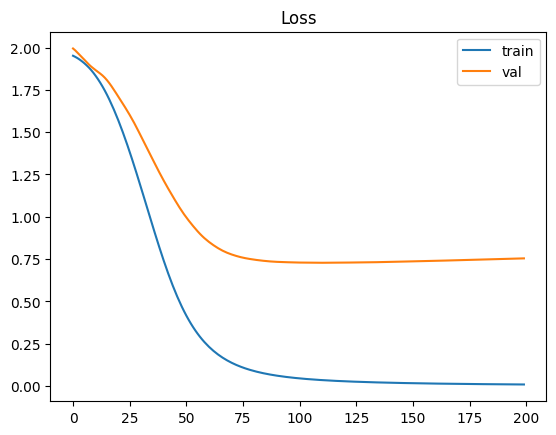

In [85]:
n_epochs = 200
for i in trange(n_epochs):

    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [86]:
with torch.no_grad():
    logits = model(graph, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.80


### 3. Graph auto-encoder

Graph auto-encoder (GAE) was proposed in [[3]](#references) as a simple node embedding model that incorporates node features. The model is consists of two parts:
* GCN node encoder $Z = \text{GCN}(X, A)$ where $X$ is the feature matrix
* Dot product decoder $\hat A = \sigma(ZZ^\top)$ where $\sigma$ is the sigmoid function

Write a class `DotProductDecoder` that takes node embeddgins and returns dot product before activation.

In [87]:
class DotProductDecoder(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, z):
        return torch.matmul(z, z.t())

In [88]:
decoder = DotProductDecoder()
assert torch.all(decoder(torch.eye(2)[:, :1]) * 2 == torch.tensor([[2, 0], [0, 0]]))

The GAE is trained to reconstruct the adjacency matrix, that is the decoder can be considered as the link prediction model. The reconstruction loss is the binary cross entropy between the adjacency matrix $A$ and reconstructed adjacency matrix $\hat A$. To overcome the imbalance between positive and negative edges, the loss is computed with positive weights — the number of negative exaples divided by the number of positive examples, that is $(|V|^2 - E)/E$.

Write a class `ReconstructionLoss` that takes reconstructed adjacency matrix and computes the binary cross entropy with positive weights `F.binary_cross_entropy_with_logits(label, target, pos_weights=...)`. The class is initialized by the adjacency matrix.

In [89]:
class ReconstructionLoss:
    def __init__(self, adj):
        self.adj = adj
        num_nodes = adj.shape[0]
        num_edges = adj.sum()
        if num_edges == 0:
            self.pos_weight = torch.tensor(1.0, device=adj.device)
        else:
            self.pos_weight = torch.tensor((num_nodes * num_nodes - num_edges) / num_edges, device=adj.device)
        self.norm = num_nodes * num_nodes / float((num_nodes * num_nodes - num_edges) * 2)

    def __call__(self, rec_adj):
        return F.binary_cross_entropy_with_logits(rec_adj, self.adj, pos_weight=self.pos_weight)

In [90]:
rec_loss = ReconstructionLoss(torch.eye(2))
assert round(rec_loss(1 - torch.eye(2)).item(), 4) == 1.0032

Here we initialize encoder, decoder, reconstruction loss and optimizer.

In [91]:
encoder = GCNMessagePassing(in_dim=1433, hid_dim=64, out_dim=32)
decoder = DotProductDecoder()
rec_loss = ReconstructionLoss(adj)
opt = Adam(encoder.parameters(), lr=0.02)
log = []

Complete the training loop for GAE. Train the model in unsupervised setting: calculate the reconstruction loss over all edges.

  0%|          | 0/400 [00:00<?, ?it/s]

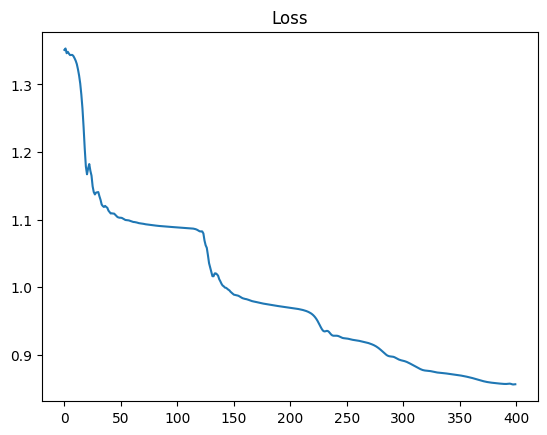

In [92]:
n_epochs = 400
for i in trange(n_epochs):
    encoder.train()

    z = encoder(graph, feat)
    rec_adj = decoder(z)
    loss = rec_loss(rec_adj)

    opt.zero_grad()
    loss.backward()
    opt.step()

    log.append(loss.item())

plt.plot(np.array(log))
plt.title('Loss')
plt.show()

We evaluate GAE by obtaining node embeddings via GCN encoder and training the logistic regression for node classification task.

In [93]:
with torch.no_grad():
    X = encoder.forward(graph, feat).numpy()
y = label.numpy()

lr = LogisticRegression()
lr.fit(X[train_mask], y[train_mask])

y_true = y[test_mask]
y_pred = lr.predict(X[test_mask])
score = balanced_accuracy_score(y_true, y_pred)
assert score >= 0.6
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.75


Let us visualize node embeddings via t-SNE.

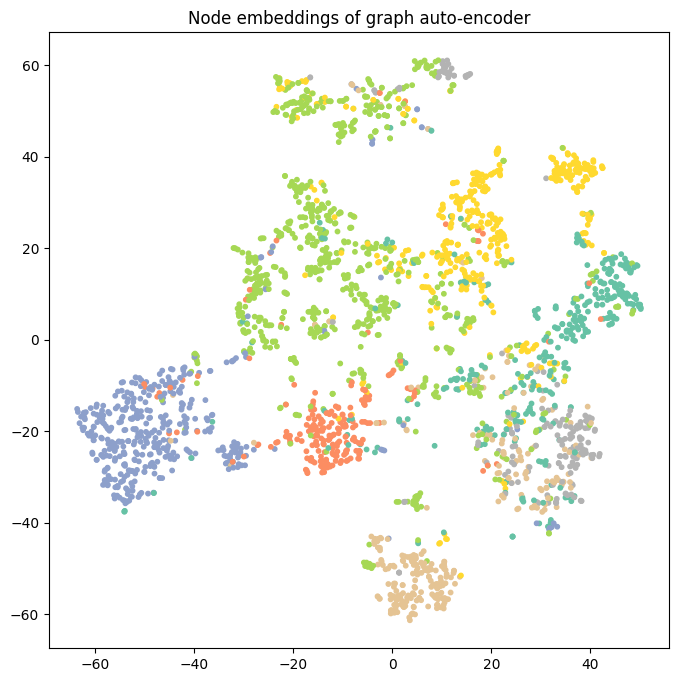

In [94]:
xy_emb = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(8, 8))
plt.title('Node embeddings of graph auto-encoder')
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=label, s=10, cmap=plt.cm.Set2)

Note that GAE is the simplest encoder-decoder graph model that can be extended to the variational graph auto-encoder (VGAE) [[3]](#references) and GraphVAE [[4]](#references).

### 4. Graph attention network

The graph attention network (GAT) was proposed in [[5]](#references). The idea behind GAT is based on the multi-head self-attention mechanism [[6]](#references). The graph attention layer is defined by message passing as follows:

$$h_i^{l} = \sum_{j \in \mathcal{N}(i)}\alpha_{ij}^{l}W_\text{node}^{l}h_j^{l-1}$$

where $\alpha_{ij}$ is the attention score defined on each edge:

$$\alpha_{ij}^{l} = \text{Softmax}_i(e_{ij}^{l})$$

where $e_{ij}^{l}$ is the edge hidden state obtained by the linear transformation of concatenatenated nodes' hidden states and subsequent LeakyReLU activation:

$$e_{ij}^{l} = \text{LeakyReLU}(W_\text{edge}^l[W_\text{node}^{l}h_i^{l-1}||W_\text{node}^{l}h_j^{l-1}])$$

where $[\cdot||\cdot]$ is concatenation. The multi-head self-attention is defined by different types of attention score (heads) $(\alpha_{ij}^{l})_0, (\alpha_{ij}^{l})_1, ..., (\alpha_{ij}^{l})_N,$. The final node's hidden state is obtained by concatenation all heads' outputs.

Here is the GAT layer that calculates nodes' preliminary hidden states by `self.fc` ($W_\text{node}$) layer and copies them to the node feature `z`, then concatenates them on edges by `edge_cat` function and copies to the edge feature `z`, then calculates attention score by `self.attn_fc` ($W_\text{edge}$) layer and performs message passing. At the end, it concatenates the next hidden states from all heads.

_Remark: `graph.apply_edges` applies an edge-wise function on all edges in the graph._

In [95]:
class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, n_heads):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.n_heads = n_heads
        attn_fc = []
        for _ in range(n_heads):
            attn_fc.append(nn.Linear(2 * out_dim, 1))
        self.attn_fc = nn.ModuleList(attn_fc)

    def forward(self, graph, feat):
        with graph.local_scope():
            graph = graph.add_self_loop()
            graph.ndata['z'] = self.fc(feat)
            graph.apply_edges(edge_cat)
            edge_z = graph.edata['z']
            h = []
            for i in range(self.n_heads):
                graph.edata['e'] = F.leaky_relu(self.attn_fc[i](edge_z))
                graph.update_all(message_func, reduce_func)
                h.append(graph.ndata['h'])
            return torch.cat(h, dim=1)

In DGL, we can implement specific functions that can be applied on edges or nodes. Let us define an edge-wise function that concatenates nodes' preliminary hidden states `z` and copies them to the edge feature `z`. It takes a batch of edges `dgl.udf.EdgeBatch` which contains source node features in the attribute `src`, destination node features in the attribute `dst` and edge features in the attribute `data`. For example:
* `edges.src['z']` is the source node feature `z`
* `edges.dst['z']` is the destination node feature `z`
* `edges.data['e']` is the edges feature `e`

Write a function `edge_cat` that takes a batch of edges and returns a dictionary where the key is `z` and the value is concatenated the source node feature `z` and the destination node feature `z`.

In [96]:
def edge_cat(edges):
    return {'z': torch.cat([edges.src['z'], edges.dst['z']], dim=1)}

In [97]:
class EdgeBatch:
    def __init__(self):
        self.src = {'z': torch.arange(10).tile(3, 1)}
        self.dst = {'z': torch.arange(10, 20).tile(3, 1)}
        self.data = {'e': torch.arange(20).tile(5, 1)}
edges = EdgeBatch()
res = edge_cat(edges)
assert res['z'].shape == (3, 20)
assert torch.all(res['z'][0] == torch.arange(20))

Next, implement the message function. Message function simply copies the source nodes' feature `z` and edges' feature `e` into mailboxes `z` and `e`.

Write a function `message_func` that takes a batch of edges and returns a dictionary:
* the key is `z`, the value is source nodes' feature `z`
* the key is `e`, the value is edges' feature `e`

In [98]:
def message_func(edges):
    return {'z': edges.src['z'], 'e': edges.data['e']}

In [99]:
class EdgeBatch:
    def __init__(self):
        self.src = {'z': torch.arange(10).tile(3, 1)}
        self.dst = {'z': torch.arange(10, 20).tile(3, 1)}
        self.data = {'e': torch.arange(20).tile(5, 1)}
edges = EdgeBatch()
res = message_func(edges)
assert res['z'].shape == (3, 10)
assert torch.all(res['z'][0] == torch.arange(10))
assert res['e'].shape == (5, 20)
assert torch.all(res['e'][0] == torch.arange(20))

The reduce funtion takes a batch of nodes `dgl.udf.NodeBatch` and calculates the next hidden states of nodes by summation of preliminary hidden states `z` weighted by attention score:
$$\alpha_{ij} = \text{Softmax}_i(e_{ij})$$
$$h_i = \sum_{j \in \mathcal{N}(i)}\alpha_{ij}z_j$$

The batch of nodes contains incoming messages in the attribute `mailbox` of the shape (N, D, 1), where N is the number of nodes in the batch, D is the number of messages received per node for this node batch.

Write a function `reduce_func` that takes a batch of nodes with mailboxes `z` and `e` and returns a dictionary where the key is `h`, the value is the next hidden states of nodes.

In [100]:
def reduce_func(nodes):
    alpha = F.softmax(nodes.mailbox['e'], dim=1)
    return {'h': torch.sum(alpha * nodes.mailbox['z'], dim=1)}

In [101]:
class NodeBatch:
    def __init__(self):
        self.mailbox = dict()
        self.mailbox['e'] = torch.arange(10, 20, dtype=float).tile(3, 1)[..., None]
        self.mailbox['z'] = torch.arange(10, dtype=float).tile(3, 1)[..., None]
nodes = NodeBatch()
assert reduce_func(nodes)['h'].shape == (3, 1)
assert round(reduce_func(nodes)['h'][0].item(), 4) == 8.4185

Write a class `GAT` that takes a graph and a feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden, output dimensions and the number of heads in the first layer. The second layer contains a single head.

In [102]:
class GAT(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_heads):
        super().__init__()
        self.conv1 = GATLayer(in_dim, hid_dim, n_heads)
        self.conv2 = GATLayer(hid_dim * n_heads, out_dim, 1) # Second layer has 1 head

    def forward(self, graph, feat):
        h = self.conv1(graph, feat)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [103]:
model = GAT(2708, 32, 7, n_heads=4)
logits = model.conv1(graph, torch.eye(2708))
assert logits.shape == (2708, 128)
logits = model(graph, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

Let us initialize the model and the optimizer.

In [104]:
model = GAT(in_dim=1433, hid_dim=16, out_dim=7, n_heads=3)
opt = Adam(model.parameters(), lr=0.005, weight_decay=0.001)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/120 [00:00<?, ?it/s]

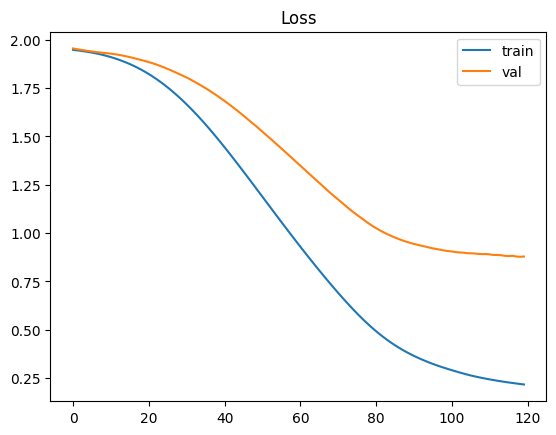

In [105]:
n_epochs = 120
for i in trange(n_epochs):

    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [106]:
with torch.no_grad():
    logits = model(graph, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.75


We can explain model's predictions using GAT — neighbors with large attention score have the great impact to model's prediction. Let us calculate the neighbors importance using the attention score.

Write a function `neighbor_importance` that takes a node index for which we want to explain the prediction, a trained GAT, a graph and a feature matrix. It returns a tuple:
* np.array with indices of neighbors
* np.array with attention scores on the first GAT layer for each neighbor. Attention score is averaged among all heads.

_Hint: use `graph.predecessors` to obtain neighbors_

In [107]:
# Just before testing neighbor_importance
data = CoraGraphDataset(force_reload=False) # force_reload=True if you want to be absolutely sure
graph = data[0]
feat = graph.ndata['feat']
# ... rest of the setup for neighbor_importance call

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [108]:
def neighbor_importance(expl_node, model, graph, feat):
    dgl.add_self_loop(graph)
    with torch.no_grad(), graph.local_scope():
        g = graph.add_self_loop()
        h_trans = model.conv1.fc(feat)
        g.ndata['h_trans'] = h_trans
        def _cat(edges):
            return {'concat': torch.cat([edges.src['h_trans'], edges.dst['h_trans']], dim=1)}
        g.apply_edges(_cat)
        edge_feat = g.edata['concat']
        head_alphas = []
        for attn_fc in model.conv1.attn_fc:
            e = F.leaky_relu(attn_fc(edge_feat))
            α = dgl.nn.functional.edge_softmax(g, e)
            head_alphas.append(α)
        avg_alpha = torch.mean(torch.stack(head_alphas, dim=0), dim=0)

        src_nodes, _, edge_ids = g.in_edges(expl_node, form='all')

        attns = avg_alpha[edge_ids].squeeze()

        return src_nodes.cpu().numpy(), attns.cpu().numpy()


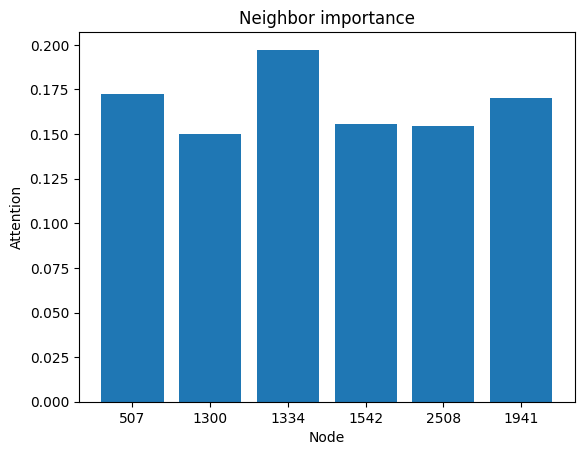

In [109]:
neigh, attn = neighbor_importance(1941, model, graph, feat)
assert type(neigh) == type(attn) == np.ndarray
assert neigh.shape == attn.shape and neigh.shape in {(6,), (7,)}
assert round(attn.sum(), 2) == 1

plt.bar(neigh.astype('str'), attn)
plt.xlabel('Node')
plt.ylabel('Attention')
plt.title('Neighbor importance')
plt.show()

### 5. Neighbor sampling with GraphSAGE

GraphSAGE (SAmple and AggreGatE) was proposed in [[7]](#references) as a model for inductive representation learning on large graph. There are two main things:
* Neighbor sampling allows to train models in mini-batches, that is the model can be trained on large graphs and it also can represent previously unseen nodes (semi-supervised inductive learning)
* Aggregation is perfomed separately on neighboring nodes and the node itself, that can be considered as "skip-connections" in graph neural networks

Neighbor sampling is a technique to construct a message flow graph by randomly sampled neighbors of a target node.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/neighbor_sampling.png' width=800>

In DGL, neighbor sampling is performed by `DataLoader`. First, we create sets of indices with train, validation and test nodes.

In [110]:
train_nids = graph.nodes()[train_mask]
val_nids = graph.nodes()[val_mask]
test_nids = graph.nodes()[test_mask]
train_nids[:5], val_nids[:5], test_nids[:5]

(tensor([0, 1, 2, 3, 4]),
 tensor([140, 141, 142, 143, 144]),
 tensor([1708, 1709, 1710, 1711, 1712]))

Next, we create `NeighborSampler` with given number of neighbors for each layer of our network. Let it be 4 neihbors for the first layer and 4 neighbors for the second. Next, we create dataloader with the sampler.

In [111]:
sampler = dgl.dataloading.NeighborSampler(fanouts=[4, 4])
train_dataloader = dgl.dataloading.DataLoader(graph, train_nids, sampler, batch_size=1)
len(train_dataloader)

140

We have set batch size is 1, that is each batch contains a single target node. The number of train nodes is 140. Dataloader iterates over:
* input nodes — the nodes from which we collect messages in the first layer
* output nodes — the target nodes that aggregate messages from neighbors in the second layers
* message flow graphs — list of graphs for layers

In [112]:
for input_nodes, output_nodes, mfgs in train_dataloader:
    break
input_nodes, output_nodes

(tensor([   0, 2582,  633, 1862, 1166, 1866, 1701,  926]), tensor([0]))

In [113]:
mfgs

[Block(num_src_nodes=8, num_dst_nodes=4, num_edges=13),
 Block(num_src_nodes=4, num_dst_nodes=1, num_edges=3)]

In [114]:
mfgs[0].edges()

(tensor([3, 2, 1, 3, 4, 0, 0, 5, 6, 0, 6, 1, 7]),
 tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]))

The message flow graph (MFG) for the second layer consists of neighbors of the target nodes. Note that indices of nodes in MFG differs from indices in the original graph to optimize the message passing.

In [115]:
mfgs[1].srcnodes(), mfgs[1].dstnodes()

(tensor([0, 1, 2, 3]), tensor([0]))

MFG is bipartite, that is messages are passing from neighbors (source nodes) 0, 1, 2, 3 to the target (destination) node 0.

In [116]:
mfgs[0].edges()

(tensor([3, 2, 1, 3, 4, 0, 0, 5, 6, 0, 6, 1, 7]),
 tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]))

The first MFG consists of edges that follow from source nodes in the first layer (0, 1, 2, 3, 4, 5, 6, 7) to sourse nodes in the second layer (0, 1, 2, 3). Let us create train, validation and test dataloaders with batch size 64.

In [117]:
train_dataloader = dgl.dataloading.DataLoader(graph, train_nids, sampler, batch_size=64)
val_dataloader = dgl.dataloading.DataLoader(graph, val_nids, sampler, batch_size=64)
test_dataloader = dgl.dataloading.DataLoader(graph, test_nids, sampler, batch_size=64)
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(3, 8, 16)

GraphSAGE is defined by message passing:

$$h_i^l = W^l[h_i^{l-1} || \text{Aggregation}_{j \in \mathcal{N}(i)}(h_j^{l-1})]$$

where $[\cdot||\cdot]$ is concatenation. Aggregation function may be represented by average, maximum or LSTM. Let us define two-layer GraphSAGE with average aggregation and intermediate ReLU activation. `SAGEConv` layer takes the MFG and features of source node, returns the hidden of destinations nodes.

Write a function `forward` that takes MFGs, feature matrix for input nodes and returns the next hidden states of output nodes.

In [118]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid_dim, aggregator_type='mean')
        self.conv2 = SAGEConv(hid_dim, out_dim, aggregator_type='mean')

    def forward(self, mfgs, feat):
        # YOUR CODE HERE
        h = self.conv1(mfgs[0], feat)
        h = F.relu(h)
        h = self.conv2(mfgs[1], h)
        return h

        #raise NotImplementedError()

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

Write a function `train_epoch` that takes GraphSAGE model, train dataloader, validation dataloader, the full feature matrix, labels and optimizer. It returns a tuple: the average train loss and the average validation loss.

In [119]:
def train_epoch(model, train_dataloader, val_dataloader, feat, label, opt):
    # YOUR CODE HERE
    #raise NotImplementedError()
    train_loss_list, val_loss_list = [], []
    for input_nodes, output_nodes, mfgs in train_dataloader:
      logits = model(mfgs, feat[input_nodes])
      train_loss = F.cross_entropy(logits, label[output_nodes])

      opt.zero_grad()
      train_loss.backward()
      opt.step()

      train_loss_list.append(train_loss.item())
    for input_nodes, output_nodes, mfgs in val_dataloader:
      with torch.no_grad():
        logits = model(mfgs, feat[input_nodes])
        val_loss = F.cross_entropy(logits, label[output_nodes])


      val_loss_list.append(val_loss.item())

    return float(np.array(train_loss_list).mean()), float(np.array(val_loss_list).mean())



In [120]:
model = GraphSAGE(1433, 16, 7)
opt = Adam(model.parameters(), lr=0.1)
train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
assert type(train_loss) == float
assert type(val_loss) == float
assert 1.8 < train_loss < 2.2
assert 1.8 < val_loss < 2.2
train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
assert train_loss < val_loss

In [121]:
train_loss

1.3826604684193928

Initialize the model and optimizers.

In [122]:
model = GraphSAGE(1433, 16, 7)
opt = Adam(model.parameters(), lr=0.01)

Train the model.

  0%|          | 0/50 [00:00<?, ?it/s]

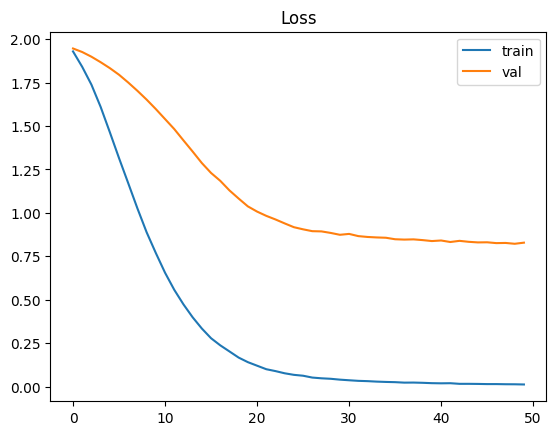

In [123]:
log = []
n_epochs = 50
for i in trange(n_epochs):
    train_loss, val_loss = train_epoch(model, train_dataloader, val_dataloader, feat, label, opt)
    log.append([train_loss, val_loss])
plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [124]:
logits = []
for input_nodes, output_nodes, mfgs in test_dataloader:
    with torch.no_grad():
        logits.append(model(mfgs, feat[input_nodes]))
logits = torch.cat(logits)
y_pred = torch.argmax(logits, 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.77


### References

<a id='references'></a>

[1] Kipf, T. N., & Welling, M. (2016). Semi-Supervised Classification with Graph Convolutional Networks. CoRR, abs/1609.02907. http://arxiv.org/abs/1609.02907

[2] Gilmer, J., Schoenholz, S. S., Riley, P. F., Vinyals, O., & Dahl, G. E. (2017). Neural Message Passing for Quantum Chemistry. CoRR, abs/1704.01212. http://arxiv.org/abs/1704.01212

[3] Kipf, T. N., & Welling, M. (2016). Variational Graph Auto-Encoders. arXiv. https://doi.org/10.48550/ARXIV.1611.07308

[4] Simonovsky, M., & Komodakis, N. (2018). GraphVAE: Towards Generation of Small Graphs Using Variational Autoencoders. CoRR, abs/1802.03480. http://arxiv.org/abs/1802.03480

[5] Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2017). Graph Attention Networks. arXiv. https://doi.org/10.48550/ARXIV.1710.10903

[6] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). Attention Is All You Need. CoRR, abs/1706.03762. http://arxiv.org/abs/1706.03762

[7] Hamilton, W. L., Ying, R., & Leskovec, J. (2017). Inductive Representation Learning on Large Graphs. CoRR, abs/1706.02216. http://arxiv.org/abs/1706.02216